# Simple classifier

---

Aditya Marathe

**Aims**:

- Create a classification model to select signal events from data.
- This model aims to replace the containment, and PID cuts.
    - Note: I decided to also include PID cut into this becasue it is also quite inefficient and we need to have a large enough background, since classification models are proven to work quite well in low signal senarios.

## Imports

In [1]:
import os
import sys

import pathlib

In [2]:
from typing import Any

In [3]:
%matplotlib inline

import dotenv

import h5py
import pandas as pd

import json

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local imports**:

In [4]:
sys.path.insert(1, './../')

from cuts import *
from utils import *

**Version and hardware**:

In [5]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
Matplotlib 3.8.1


In [6]:
# The '.env' file contains the directory to the data.
dotenv.load_dotenv();

## The data

In [7]:
df_dir = os.environ.get(LocalDatasets.REALLY_MINI)

In [8]:
df = load_nova_sample(
    file_path=df_dir,
    n_events=5_000_000
)

In [9]:
df.head()

,3flavourveto,ccAll,cosBeamFirst,isANuECC,isANuMuCC,isCC,isNC,isNotNu,isNuECC,isNuMu,...,rec.sel.cvnloosepreselptp.nutauid,rec.sel.remid.pid,rec.sel.scann.scpid,rec.slc.ncontplanes,rec.slc.nhit,rec.trk.cosmic.ntracks,rec.trk.kalman.ntracks,recoq2,recow,trueEnu
0,False,0,0.114537,False,False,False,False,True,False,False,...,-5.0,0.336538,0.096694,9,41,1,1,0.925479,0.610270,0.000000
1,False,0,0.825868,False,False,False,False,True,False,False,...,-5.0,0.974734,0.191486,93,309,1,1,8.439269,NaN,0.000000
2,True,0,0.580387,False,False,False,False,True,False,False,...,-5.0,0.945310,0.132330,57,318,1,1,3.127142,NaN,0.000000
3,True,1,0.926336,False,False,True,False,False,False,True,...,-5.0,0.936047,0.884369,19,43,1,1,0.099019,1.090893,0.839629
4,False,0,0.041819,False,False,False,False,True,False,False,...,-5.0,0.543133,0.087294,8,47,1,1,1.783101,0.280110,0.000000


In [10]:
def tf_290124_positive_energies(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Transform: 29/01/2024
    ---------------------
    Cuts out the negative energies caused by issues with the reco. models.
    """
    targets = [
        'rec.energy.numu.hadclust.calE',
        'rec.energy.numu.hadtrkE',
        'rec.energy.numu.lstmmuon',
        'rec.energy.numu.lstmnu',
    ]

    df_copy = df.copy()

    for target in targets:
        df_copy = df_copy[df_copy[target] > 0.]

    return df_copy

In [11]:
def tf_290124_numu_energy(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Transform: 29/01/2024
    ---------------------
    Restricts the muon-neutrino energy to be between 0 and 5.
    """
    targets = [
        'trueEnu',
        'rec.energy.numu.E',
        'rec.energy.numu.lstmnu'
    ]

    df_copy = df.copy()

    for target in targets:
        df_copy = df_copy[(df_copy[target] > 0.) & (df_copy[target] < 5.)]

    return df_copy

In [12]:
def tf_290124_valid_pid(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Transform: 29/01/2024
    ---------------------
    Ensures that the PID score is between 0 and 1.
    """
    targets = [
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.nueid',
        'rec.sel.cvnloosepreselptp.numuid',
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid'
    ]

    df_copy = df.copy()

    for target in targets:
        df_copy[(df_copy[target] < 0) & (df_copy[target] > 1)] = 0.
    
    return df_copy

In [13]:
def tf_290124_apply_cuts_1(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Transform: 29/01/2024
    ---------------------
    Applies all cuts except for the PID and containment cuts.

    This transform is to train a model which will replace the existing PID and 
    containment cuts.
    """
    nova_cuts = Cuts.init_nova_cuts()
    # All cuts except PID and containment
    df = nova_cuts.apply_all_cuts(
        df=df, 
        except_=['CVN PID Score', 'Containment']
    )
    return df

In [14]:
def tf_290124_apply_cuts_2(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Transform: 29/01/2024
    ---------------------
    Gets the data which fails PID and containment.

    This transform is to train a model which will recover data lost to the
    existing PID and containment cuts.
    """
    nova_cuts = Cuts.init_nova_cuts()
    # Keep data that fails PID and containment
    df = nova_cuts.apply_cuts(
        df=df, 
        names=['CVN PID Score', 'Containment'],
        passed=[False, False]
    )
    return df

In [15]:
tf_290124_list = [
    tf_290124_numu_energy,
    tf_290124_positive_energies,
    tf_290124_valid_pid,
    tf_290124_apply_cuts_1,
    # tf_290124_apply_cuts_2
]

df_tf = df.copy()

for transform in tf_290124_list:
    df_tf = transform(df_tf)

In [16]:
df_tf.head()

,3flavourveto,ccAll,cosBeamFirst,isANuECC,isANuMuCC,isCC,isNC,isNotNu,isNuECC,isNuMu,...,rec.sel.cvnloosepreselptp.nutauid,rec.sel.remid.pid,rec.sel.scann.scpid,rec.slc.ncontplanes,rec.slc.nhit,rec.trk.cosmic.ntracks,rec.trk.kalman.ntracks,recoq2,recow,trueEnu
8,True,0,0.935944,False,False,False,True,False,False,True,...,-5.0,0.043801,0.176936,13,30,1,1,0.066027,1.408129,1.987239
17,True,1,0.831410,False,False,True,False,False,False,True,...,-5.0,0.997171,0.970767,26,102,1,2,0.784310,1.502815,1.991945
23,True,1,0.996775,False,False,True,False,False,False,True,...,-5.0,0.971146,0.930890,29,84,1,1,0.015071,1.202431,1.667265
27,True,1,0.346634,False,False,True,False,False,False,True,...,-5.0,0.884891,0.981610,14,61,1,2,1.318372,1.291364,1.768575
30,True,0,0.676639,False,False,False,True,False,False,True,...,-5.0,0.106304,0.076847,8,28,1,1,0.221201,1.214836,1.338144


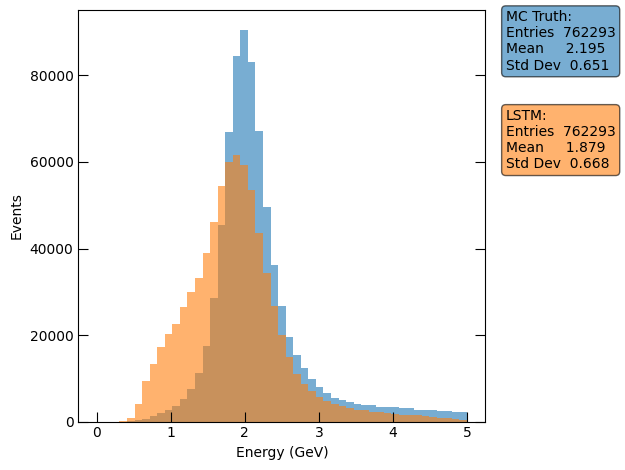

In [17]:
fig, ax = custom_subplots()

labelled_hist(
    ax, 
    df_tf['trueEnu'], 
    bins=NOVA_NUMU_ENERGY_BINS_5GEV, 
    alpha=0.6,
    label='MC Truth'
)
labelled_hist(
    ax, 
    df_tf['rec.energy.numu.lstmnu'], 
    bins=NOVA_NUMU_ENERGY_BINS_5GEV,
    alpha=0.6,
    label='LSTM'
)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Events')

plt.tight_layout();


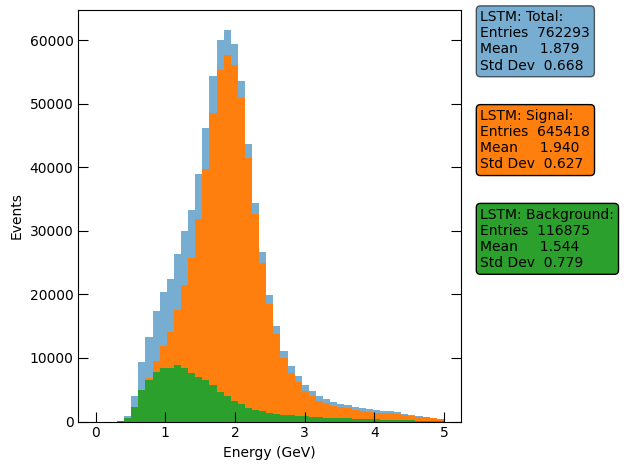

In [198]:
fig, ax = custom_subplots()

labelled_hist(
    ax, 
    df_tf[df_tf['trueEnu'] > 0]['rec.energy.numu.lstmnu'], 
    bins=NOVA_NUMU_ENERGY_BINS_5GEV,
    alpha=0.6,
    label='LSTM: Total'
)
labelled_hist(
    ax, 
    df_tf[(df_tf['trueEnu'] > 0) & (df_tf['isNuMuCC'] > 0)]['rec.energy.numu.lstmnu'], 
    bins=NOVA_NUMU_ENERGY_BINS_5GEV,
    label='LSTM: Signal'
)
labelled_hist(
    ax, 
    df_tf[(df_tf['trueEnu'] > 0) & (df_tf['isNuMuCC'] < 1)]['rec.energy.numu.lstmnu'], 
    bins=NOVA_NUMU_ENERGY_BINS_5GEV,
    label='LSTM: Background'
)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Events')

plt.tight_layout();


In [18]:
# Signal-to-background
_sig = len(df_tf[df_tf['isNuMuCC']])
_bkg = len(df[~df['isNuMuCC']])
print(f'S/B = {_sig / _bkg:0.5f}')

S/B = 0.17840


In [19]:
x_data_columns = [
    'cosBeamFirst',
    'pmu',
    'pt',
    'ptp',
    'rec.energy.numu.E',
    'rec.energy.numu.calccE',
    'rec.energy.numu.hadcalE',
    'rec.energy.numu.hadclust.calE',
    'rec.energy.numu.hadclust.nhit',
    'rec.energy.numu.hadtrkE',
    'rec.energy.numu.lstmmuon',
    'rec.energy.numu.lstmnu',
    'rec.energy.numu.regcvnhadE',
    'rec.sel.contain.cosbakcell',
    'rec.sel.cvnloosepreselptp.cosmicid',
    'rec.sel.cvnloosepreselptp.ncid',
    'rec.sel.cvnloosepreselptp.nueid',
    'rec.sel.cvnloosepreselptp.numuid',
    'rec.sel.cvnloosepreselptp.nutauid',
    'rec.sel.remid.pid',
    'rec.sel.scann.scpid',
    'rec.slc.ncontplanes',
    'rec.slc.nhit',
    'rec.trk.cosmic.ntracks',
    'rec.trk.kalman.ntracks',
    'recoq2',
    # 'recow'
]
y_data_columns = [
    'isNuMuCC'
]

## The model

In [42]:
config = {
    'Transforms': tf_290124_list,
    'XDataCols': x_data_columns,
    'YDataCols': y_data_columns,
    'Hyperparameters': {
        'Dropout #1': 0.3
    }
}

In [43]:
model_config = {
    'SequentialLayers': [
        keras.layers.InputLayer(input_shape=(len(config['XDataCols']),)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(config['Hyperparameters']['Dropout #1']),
        keras.layers.Dense(256, activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(config['Hyperparameters']['Dropout #1']),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(config['Hyperparameters']['Dropout #1']),
        keras.layers.Dense(1, activation=keras.activations.sigmoid)
    ],
    'Optimizer': keras.optimizers.Adam(learning_rate=1E-3),
    'LossFunction': keras.losses.BinaryCrossentropy(),
    'Metrics': [
        keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),
        keras.metrics.MeanSquaredError(name='mse'),
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
}

In [44]:
x_data = df_tf[config['XDataCols']]
# Below, I am converting the boolean values to 1s and 0s
# I have also used a not operation, so we are now looking to classify the
# background rather than the signal.
y_data = (~df_tf[config['YDataCols']]) * 1

# Convert to NumPy
x_data = x_data.to_numpy()
y_data = y_data.to_numpy()

# Train-test split
train_x_data = x_data[:int(x_data.shape[0] * 0.8)]
test_x_data = x_data[int(x_data.shape[0] * 0.8):]
train_y_data = y_data[:int(y_data.shape[0] * 0.8)].flatten()
test_y_data = y_data[int(y_data.shape[0] * 0.8):].flatten()

training_bkg = np.count_nonzero(train_y_data)
testing_bkg = np.count_nonzero(test_y_data)

# Standard scaler
std_scaler = preprocessing.StandardScaler()
train_x_data = std_scaler.fit_transform(train_x_data)
test_x_data = std_scaler.transform(test_x_data)

#
print(f'{train_x_data.shape = }')
print(f'{train_y_data.shape = }')
print(f'{test_x_data.shape = }')
print(f'{test_y_data.shape = }')
print()
print(f'Training: Sig = {(1 - training_bkg / len(train_y_data)) * 100:0.2f} %')
print(f'Training: Bkg = {training_bkg / len(train_y_data) * 100:0.2f} %')
print()
print(f'Testing: Sig = {(1 - testing_bkg / len(test_y_data)) * 100:0.2f} %')
print(f'Testing: Bkg = {testing_bkg / len(test_y_data) * 100:0.2f} %')

train_x_data.shape = (609834, 26)
train_y_data.shape = (609834,)
test_x_data.shape = (152459, 26)
test_y_data.shape = (152459,)

Training: Sig = 84.62 %
Training: Bkg = 15.38 %

Testing: Sig = 84.86 %
Testing: Bkg = 15.14 %


In [45]:
def compile_model(model_cnf: dict[str, Any]) -> keras.Model:
    """\
    
    """
    if 'SequentialLayers' in model_cnf:
        model = keras.Sequential(
            layers=model_cnf['SequentialLayers'],
            name='sequential'
        )

    model.compile(
        optimizer=model_cnf['Optimizer'],
        loss=model_cnf['LossFunction'],
        metrics=model_cnf['Metrics']
    )

    model.summary()

    return model

In [46]:
model = compile_model(model_config)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 26)               104       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               6912      
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_8 (Batc  (None, 256)             

In [47]:
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

history_obj = model.fit(
    x=train_x_data,
    y=train_y_data,
    validation_split=0.2,
    epochs=epochs,
    callbacks=[
        early_stopping
    ]
)

Epoch 1/100
15246/15246 [==============================] - 162s 10ms/step - loss: 0.2099 - binary_crossentropy: 0.2099 - mse: 0.0579 - tp: 53502.0000 - fp: 14375.0000 - tn: 398603.0000 - fn: 21387.0000 - binary_accuracy: 0.9267 - precision: 0.7882 - recall: 0.7144 - auc: 0.9297 - prc: 0.7753 - val_loss: 0.1882 - val_binary_crossentropy: 0.1882 - val_mse: 0.0524 - val_tp: 13596.0000 - val_fp: 2930.0000 - val_tn: 100140.0000 - val_fn: 5301.0000 - val_binary_accuracy: 0.9325 - val_precision: 0.8227 - val_recall: 0.7195 - val_auc: 0.9445 - val_prc: 0.8315
Epoch 2/100
15246/15246 [==============================] - 180s 12ms/step - loss: 0.2006 - binary_crossentropy: 0.2006 - mse: 0.0555 - tp: 53296.0000 - fp: 12897.0000 - tn: 400081.0000 - fn: 21593.0000 - binary_accuracy: 0.9293 - precision: 0.8052 - recall: 0.7117 - auc: 0.9358 - prc: 0.7972 - val_loss: 0.1862 - val_binary_crossentropy: 0.1862 - val_mse: 0.0521 - val_tp: 13938.0000 - val_fp: 3227.0000 - val_tn: 99843.0000 - val_fn: 4959.0

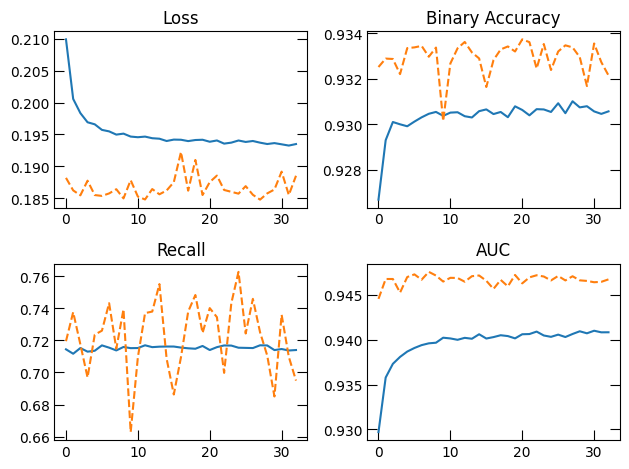

In [49]:
fig, ax = custom_subplots(2, 2)

hist_dict = history_obj.history

ax[0].set_title('Loss')
ax[0].plot(hist_dict['loss'])
ax[0].plot(hist_dict['val_loss'], '--')

ax[1].set_title('Binary Accuracy')
ax[1].plot(hist_dict['binary_accuracy'])
ax[1].plot(hist_dict['val_binary_accuracy'], '--')

ax[2].set_title('Recall')
ax[2].plot(hist_dict['recall'])
ax[2].plot(hist_dict['val_recall'], '--')

ax[3].set_title('AUC')
ax[3].plot(hist_dict['auc'])
ax[3].plot(hist_dict['val_auc'], '--')

plt.tight_layout();

In [51]:
prediction = model.predict(test_x_data)

4765/4765 [==============================] - 6s 1ms/step


In [56]:
predicted_y_data = (prediction.flatten() > 0.5) * 1

In [67]:
correct_percent = (
    np.count_nonzero((predicted_y_data == test_y_data) * 1) 
        / len(predicted_y_data) * 100
)
print(f'Correct predictions = {correct_percent:0.2f} %')

Correct predictions = 93.44 %


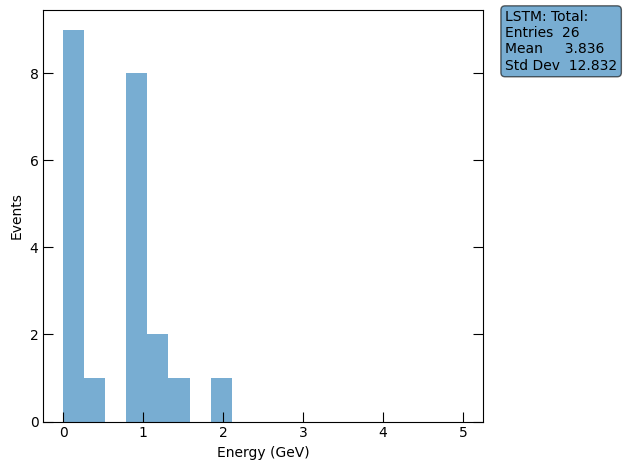

In [75]:
fig, ax = custom_subplots()

labelled_hist(
    ax, 
    std_scaler.inverse_transform(test_x_data)[11], 
    bins=np.linspace(0, 5, 20),
    alpha=0.6,
    label='LSTM: Total'
)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Events')

plt.tight_layout();
